In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import imageio
from io import BytesIO

# Directory to store the arrays
output_dir = './current_densities/'

# Ensure the directory exists (optional)
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Parameters
nc = 4.6e3          # number density n0
alpha = 7           # Decay constant
gamma = 3.3         # Decay constant for source term
sigma_y = 20
diff = 0.1             # Diffusion coefficient
t_r = 4             # Recombination time
Lx = 5              # Length in x-direction
Ly = 150            # Length in y-direction
T = 3               # Total time
Nx = 49             # Number of grid points in x-direction
Ny = 500            # Number of grid points in y-direction
Nt = 1000           # Number of time steps
t0 = 1
sigma_t = 0.02
mu = 4

dx = Lx / (Nx - 1)  # Grid spacing in x-direction
dy = Ly / (Ny - 1)  # Grid spacing in y-direction
dt = T / Nt         # Time step size

# Stability condition check
if diff * dt / dx**2 > 0.5 or diff * dt / dy**2 > 0.5:
    raise ValueError('The solution is unstable. Reduce dt or increase dx and dy.')

# Create grid using meshgrid
x = np.linspace(-Lx, Lx, Nx)
y = np.linspace(-Ly, Ly, Ny)
X, Y = np.meshgrid(x, y)

# Initial condition
eps = np.ones(X.shape)
eps[X < 0] *= 12
n_e = nc * np.exp(-alpha * X) * np.exp(-(Y**2) / (2 * sigma_y**2)) * np.exp(-t0**2 / (2 * sigma_t**2))
n_e[X < 0] = 0
n_h = np.copy(n_e)
div_neE = np.zeros_like(n_e)
phi_old = div_neE + 1e-6
matEy = []




In [5]:
from poisson_solver.fast_poisson_solver import fast_poisson_solver

def poisson_solver_traditional(n_e, n_h, x, y, epsilon_0, phi, tol, max_iter, eps):
    # Constants
    qe = -1.60217662e-19  # Elementary charge in Coulombs

    # Define the charge density
    rho = qe * (n_e - n_h)
    dx = x[1] - x[0]
    dy = y[1] - y[0]

    # Initialize the potential with the initial guess
    V = phi.copy()

    # Set boundary conditions (V = 0 at the boundaries)
    V[:, 0] = 0   # Left boundary
    V[:, -1] = 0  # Right boundary
    V[0, :] = 0   # Bottom boundary
    V[-1, :] = 0  # Top boundary

    # Iterative solver (Gauss-Seidel method)
    converged = False
    for iter in range(max_iter):
        V_old = V.copy()

        # Calculate epsilon at half-grid points
        epsilon_y1 = (eps[1:-1, 1:-1] + eps[2:, 1:-1]) / 2  # between i and i+1
        epsilon_y2 = (eps[1:-1, 1:-1] + eps[:-2, 1:-1]) / 2  # between i and i-1
        epsilon_x1 = (eps[1:-1, 1:-1] + eps[1:-1, 2:]) / 2  # between j and j+1
        epsilon_x2 = (eps[1:-1, 1:-1] + eps[1:-1, :-2]) / 2  # between j and j-1

        # Calculate the denominator
        denominator = (epsilon_x1 / dx**2 + epsilon_x2 / dx**2 +
                    epsilon_y1 / dy**2 + epsilon_y2 / dy**2)

        # Update V in the inner region
        V[1:-1, 1:-1] = (1 / denominator) * (
            epsilon_y1 * V[2:, 1:-1] / dy**2 +
            epsilon_y2 * V[:-2, 1:-1] / dy**2 +
            epsilon_x1 * V[1:-1, 2:] / dx**2 +
            epsilon_x2 * V[1:-1, :-2] / dx**2 +
            rho[1:-1, 1:-1] / epsilon_0
        )


        # Check for convergence
        if np.max(np.abs(V - V_old)) < tol:
            converged = True
            # print(f"Converged in {iter+1} iterations")
            break

    # Calculate the electric field components (negative gradient of potential)
    E_y, E_x = np.gradient(-V, dy, dx)

    # Return the electric field, potential, and convergence flag
    return E_x, E_y, V, converged


def compute_divergence_and_field(n_e, n_h, x, y, phi, eps):
    # Constants
    epsilon_0 = 8.854e-18  # Permittivity of free space

    # Set tolerance and maximum iterations for the Poisson solver
    tol = 1e-5
    max_iter = 5000
    
    # Call the Poisson solver (assumed to be defined elsewhere)
    Ex, Ey, phi, converged = fast_poisson_solver(n_e, n_h, x, y, epsilon_0, phi, tol, max_iter, eps)
    
    if converged == 0:
        print("Warning: Poisson solver not converged")

    # Compute grid spacing
    dx = x[1] - x[0]
    dy = y[1] - y[0]

    # Compute the gradients of the electron density n_e
    d_n_e_dy, d_n_e_dx = np.gradient(n_e, dy, dx)

    # Compute the gradients of the electric field components Ex and Ey
    dE_x_dy, dE_x_dx = np.gradient(Ex, dy, dx)
    dE_y_dy, dE_y_dx = np.gradient(Ey, dy, dx)

    # Apply the product rule to compute the divergence of n_e * E
    div_neE = Ex * d_n_e_dx + Ey * d_n_e_dy + n_e * (dE_x_dx + dE_y_dy)

    return Ex, Ey, div_neE, phi



# Function to compute current
def compute_current(n_e, Ex, Ey, D, mu, dx, dy):
    q = 1.6e-19
    d_n_e_dy, d_n_e_dx = np.gradient(n_e, dy, dx)
    jx = -q * D * d_n_e_dx + q * mu * n_e * Ex
    jy = -q * D * d_n_e_dy + q * mu * n_e * Ey
    return jx, jy



def initialize_plots(params):
    global fig, ax_list, im_list

    # Create figure and subplots
    fig, ax_list = plt.subplots(2, 3, figsize=(12, 8))
    im_list = []  # Clear the list before creating new images

    # Create a subplot for n_e
    ax = ax_list[0, 0]
    im_n_e = ax.imshow(params['n_e'], extent=[params['x'][0], params['x'][-1], params['y'][0], params['y'][-1]], origin='lower', aspect='auto')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"Electron Density at t = {params['n'] * params['dt']}")
    cbar_n_e = fig.colorbar(im_n_e, ax=ax)
    im_list.append(im_n_e)

    # Create a subplot for n_h
    ax = ax_list[0, 1]
    im_n_h = ax.imshow(params['n_h'], extent=[params['x'][0], params['x'][-1], params['y'][0], params['y'][-1]], origin='lower', aspect='auto')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"Hole Density at t = {params['n'] * params['dt']}")
    cbar_n_h = fig.colorbar(im_n_h, ax=ax)
    im_list.append(im_n_h)

    # Create a subplot for source_term
    ax = ax_list[0, 2]
    im_source = ax.imshow(params['source_term'], extent=[params['x'][0], params['x'][-1], params['y'][0], params['y'][-1]], origin='lower', aspect='auto')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"Source Density at t = {params['n'] * params['dt']}")
    cbar_source = fig.colorbar(im_source, ax=ax)
    im_list.append(im_source)

    # Create a subplot for Jx
    ax = ax_list[1, 0]
    im_jx = ax.imshow(params['jx'], extent=[params['x'][0], params['x'][-1], params['y'][0], params['y'][-1]], origin='lower', aspect='auto')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"Jx at t = {params['n'] * params['dt']}")
    cbar_jx = fig.colorbar(im_jx, ax=ax)
    im_list.append(im_jx)

    # Create a subplot for Jy
    ax = ax_list[1, 1]
    im_jy = ax.imshow(params['jy'], extent=[params['x'][0], params['x'][-1], params['y'][0], params['y'][-1]], origin='lower', aspect='auto')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"Jy at t = {params['n'] * params['dt']}")
    cbar_jy = fig.colorbar(im_jy, ax=ax)
    im_list.append(im_jy)

    plt.tight_layout()
    # plt.draw()
    # display(fig)  # Ensure it is displayed in Jupyter

def plot_results(params):
    global im_list

    # Clear the output for dynamic update
    clear_output(wait=True)

    # Update data in each plot
    # Update data in each plot and the titles
    for i, key in enumerate(['n_e', 'n_h', 'source_term', 'jx', 'jy']):
        im_list[i].set_data(params[key])  # Update data
        im_list[i].set_extent([params['x'][0], params['x'][-1], params['y'][0], params['y'][-1]])  # Reset extent
        im_list[i].set_clim(vmin=np.min(params[key]), vmax=np.max(params[key]))  # Set color limits

        # Update the title with the current time
        ax_list[i // 3, i % 3].set_title(f"{key.replace('_', ' ').title()} at t = {params['n'] * params['dt']:.2f}")




    # Redraw the plot with updated data and color scales
    # plt.draw()  
    # plt.pause(0.001)  # Pause briefly to allow updates
    # display(fig)  # Display again in case it's needed for Jupyter

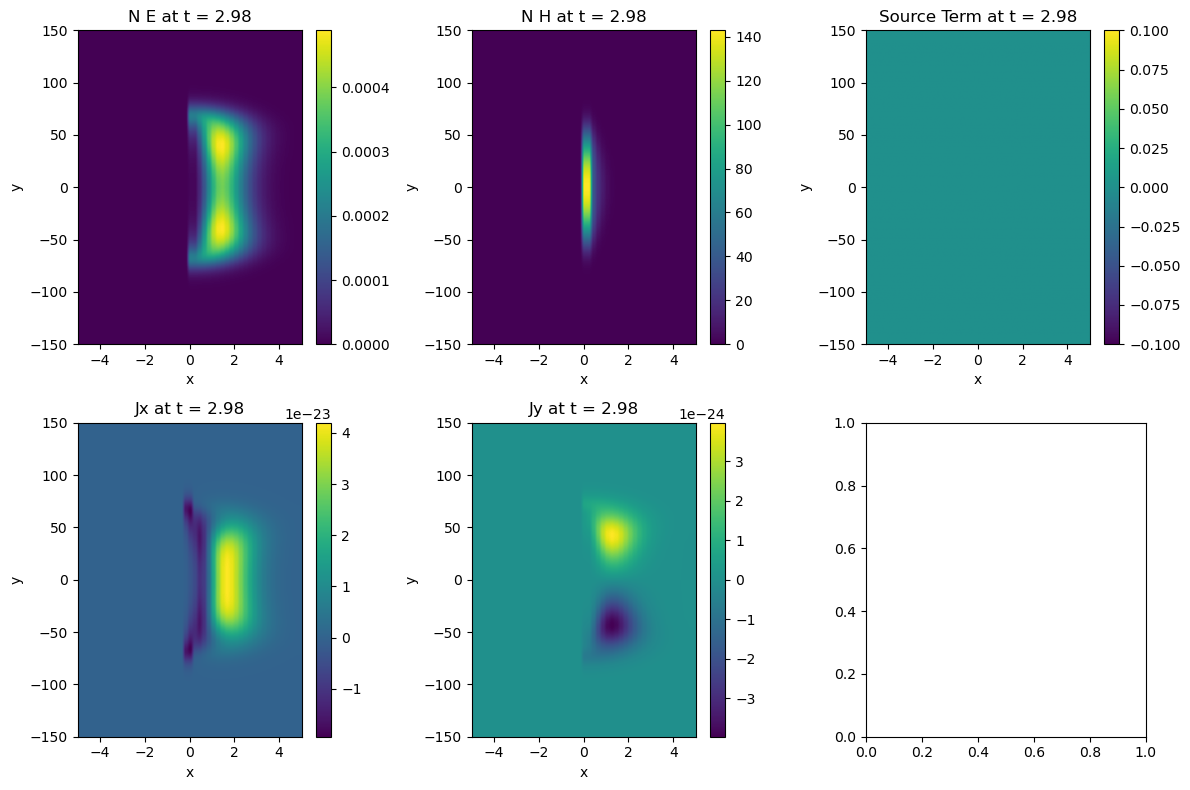

In [9]:
# Initialize figure and axis objects globally
fig, ax_list = None, None
im_list = []  # To store image objects
frames = []
# plt.ion()
# Time-stepping loop


# Initialize storage for jx and jy
Xr, Yr = np.meshgrid(x[x>=0], y[abs(y)<100])
jx_storage = np.zeros((*np.shape(Xr), Nt))
jy_storage = np.zeros((*np.shape(Xr), Nt))

for n in range(Nt):
    n_e_new = np.copy(n_e)
    n_h_new = np.copy(n_h)

    # Calculate source term
    source_term = nc * (1 / np.sqrt(2 * np.pi * sigma_t**2)) * np.exp(-alpha * X) * \
                  np.exp(-(Y**2) / (2 * sigma_y**2)) * np.exp(-((n * dt - t0)**2) / (2 * sigma_t**2))
    source_term[X < 0] = 0

    # Finite difference for second-order derivatives
    d2_n_e_dy2 = (n_e[2:, 1:-1] - 2 * n_e[1:-1, 1:-1] + n_e[:-2, 1:-1]) / dy**2
    d2_n_e_dx2 = (n_e[1:-1, 2:] - 2 * n_e[1:-1, 1:-1] + n_e[1:-1, :-2]) / dx**2

    # Update electron density
    dn_dt = np.zeros_like(n_e)
    dn_dt[1:-1, 1:-1] = diff * (d2_n_e_dx2 + d2_n_e_dy2) + source_term[1:-1, 1:-1] - \
                        (n_h[1:-1, 1:-1] * n_e[1:-1, 1:-1] / t_r) + mu * div_neE[1:-1, 1:-1] - \
                        n_e[1:-1, 1:-1] * gamma
    n_e_new[1:-1, 1:-1] += dt * dn_dt[1:-1, 1:-1]

    n_h_new[1:-1, 1:-1] += dt * (-n_h[1:-1, 1:-1] * n_e[1:-1, 1:-1] / t_r + source_term[1:-1, 1:-1])

    # Reflecting boundary at x = 0
    n_e_new[: , Nx//2] = n_e_new[:, Nx//2 + 1]
    n_h_new[: , Nx//2] = n_h_new[:, Nx//2 + 1]

    # Absorbing boundary conditions
    n_e_new[0, :] = n_e_new[-1, :] = 0
    n_e_new[:, 0] = n_e_new[:, -1] = 0
    n_h_new[0, :] = n_h_new[-1, :] = 0
    n_h_new[:, 0] = n_h_new[:, -1] = 0

    n_e_new[:, 0:Nx//2] = 0
    n_h_new[:, 0:Nx//2] = 0
    # Update n_e and n_h for the next time step
    n_e = n_e_new
    n_h = n_h_new

    # Compute divergence for the next iteration
    Ex, Ey, div_neE, phi_old = compute_divergence_and_field(n_e, n_h, x, y, phi_old, eps)
    jx, jy = compute_current(n_e, Ex, Ey, diff, mu, dx, dy)

        # Store the current jx and jy values in the storage arrays
    jx_storage[:, :, n] = np.reshape(jx[(X >= 0) & (np.abs(Y) < 100)], np.shape(Xr))
    jy_storage[:, :, n] = np.reshape(jy[(X >= 0) & (np.abs(Y) < 100)], np.shape(Xr))


    # Collect results and plot every 20 steps
    if n % 5 == 0:
        params = {
            'n': n, 'dt': dt, 'x': x, 'y': y, 'n_e': n_e, 'n_h': n_h,
            'source_term': source_term, 'Ex': Ex, 'Ey': Ey, 'X': X, 'Y': Y,
            'nc': nc, 'jx': jx, 'jy': jy, 'dn_dt': dn_dt
        }
        if n == 0:
            print("init")
            initialize_plots(params)
            buf = BytesIO()
        else:
            plot_results(params)
            buf = BytesIO()
    
        # Save current plot to an in-memory buffer
        

        
        plt.savefig(buf, format='png')
        buf.seek(0)
        
        # Read the image from the buffer and append it to the frames list
        frames.append(imageio.v2.imread(buf))
        buf.close()
        
        # Close the buffer
    
            
# After the loop finishes, save the 3D arrays to .npy files
# Create GIF from frames
imageio.mimsave('numerical_diffusion_equation/simulation.gif', frames, fps=10)
np.save(os.path.join(output_dir, 'jx_storage.npy'), jx_storage)
np.save(os.path.join(output_dir, 'jy_storage.npy'), jy_storage)




In [ ]:
from current_densities.current_interpolation import setup_interpolators, get_jx_jy_at

def current_photodember_drift_diffusion(xprime, yprime):
    """Returns a function to get jx at a specific t for given (xprime, yprime)."""
    def jx_t(t):
        return get_jx_jy_at(xprime, yprime, t, jx_interpolator)
    return jx_t 

# Setup interpolators
jx_interpolator, jy_interpolator = setup_interpolators()

# Example usage
jxp = current_photodember_drift_diffusion(2, 2)
jxp(2)


In [ ]:
from interp3d.interp3d import interp_3d
import numpy as np

x = np.linspace(0,2.5,100)
y = np.linspace(-1,.5,50)
z = np.linspace(5,25,125)

X,Y,Z = np.meshgrid(x,y,z,indexing='ij')
arr = X+2*Y-3*Z

interp = interp_3d.Interp3D(arr, x,y,z)

from scipy.interpolate import RegularGridInterpolator
interp_si = RegularGridInterpolator((x,y,z),arr)

x0, y0, z0 = (1.1,0.25, 7.5)
print('this class {}'.format(interp((x0,y0,z0))))
print('scipy.interpolate.RegularGridInterpolator() {}'.format(interp_si((x0,y0,z0)), x0+2*y0-3*z0))
print('exact {}'.format(x0+2*y0-3*z0))